# Train Stats

```
 ----------------------------------------------------------------------------------------
/                                                                                        \
| /$$$$$$$$                 /$$            /$$$$$$   /$$                 /$$             |
||__  $$__/                |__/           /$$__  $$ | $$                | $$             |
|   | $$  /$$$$$$  /$$$$$$  /$$ /$$$$$$$ | $$  \__//$$$$$$    /$$$$$$  /$$$$$$   /$$$$$$$|
|   | $$ /$$__  $$|____  $$| $$| $$__  $$|  $$$$$$|_  $$_/   |____  $$|_  $$_/  /$$_____/|
|   | $$| $$  \__/ /$$$$$$$| $$| $$  \ $$ \____  $$ | $$      /$$$$$$$  | $$   |  $$$$$$ |
|   | $$| $$      /$$__  $$| $$| $$  | $$ /$$  \ $$ | $$ /$$ /$$__  $$  | $$ /$$\____  $$|
|   | $$| $$     |  $$$$$$$| $$| $$  | $$|  $$$$$$/ |  $$$$/|  $$$$$$$  |  $$$$//$$$$$$$/|
|   |__/|__/      \_______/|__/|__/  |__/ \______/   \___/   \_______/   \___/ |_______/ |
|                                                                                        |
|                                                                                        |
|                                                                                        |
|                                      🚂 ¯\_(ツ)_/¯?                                     |
\                                                                                        /
 ----------------------------------------------------------------------------------------
    \     
     \     
      \      
           ___ ____
         ⎛   ⎛ ,----
          \  //==--'
     _//|,.·//==--'    ____________________________
    _OO≣=-  ︶ ᴹw ⎞_§ ______  ___\ ___\ ,\__ \/ __ \
   (∞)_, )  (     |  ______/__  \/ /__ / /_/ / /_/ /
     ¨--¨|| |- (  / ______\____/ \___/ \__^_/  .__/
         ««_/  «_/ jgs/bd808                /_/
```

In which I look at data from the past several hundred trains and pretend that I know how to do exploratory data analysis.

In [2]:
import pandas as pdb
from matplotlib import pyplot as plt
import seaborn as sns

import glob

# Makes your data 538% better...I think
plt.style.use('fivethirtyeight')

# ಠ_ಠ This is the rotten, no good, very bad way pandas makes you read csv files in a loop ಠ_ಠ
dfs = [pdb.read_csv(f'{train}') for train in glob.glob('data/*.csv')]
df = pdb.concat(dfs, axis=0, ignore_index=True)

# 🧐 Preliminary thinking

thinking....

Looking at the dataset desribed below it mostly looks correct. I note that the max of the `group[N]_delay_days` is `6` for every day and I'm doing some `N % 7` math somewhere on `.isoweekday()` so that's probably under-reporting. Overall the data looks ok. 👌

In [3]:
df.describe()

,insertions,deletions,loc_change,total_comment_count,time_in_review,patches,rollbacks,rollbacks_time,group0_delay_days,group1_delay_days,group2_delay_days,train_total_time
count,5.725200e+04,57252.000000,5.725200e+04,57252.000000,5.725200e+04,57252.000000,57252.000000,5.725200e+04,57252.000000,57252.000000,57252.000000,5.725200e+04
mean,4.261585e+02,75.700989,5.018595e+02,3.151925,9.348383e+05,461.719241,0.957958,9.780326e+04,0.469084,0.910117,1.176745,2.839957e+05
std,7.230130e+04,2453.631914,7.242068e+04,4.796869,5.297748e+06,183.902004,1.070532,1.816600e+05,1.324611,1.767145,1.997625,2.260752e+05
min,0.000000e+00,0.000000,0.000000e+00,0.000000,6.000000e+00,172.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,6.384400e+04
25%,2.000000e+00,1.000000,4.000000e+00,1.000000,3.830750e+03,319.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1.723180e+05
50%,6.000000e+00,4.000000,1.200000e+01,2.000000,4.623350e+04,410.000000,1.000000,4.011000e+03,0.000000,0.000000,0.000000,1.788110e+05
75%,3.000000e+01,16.000000,5.400000e+01,4.000000,3.298928e+05,612.000000,2.000000,9.449300e+04,0.000000,1.000000,1.000000,2.550750e+05
max,1.728860e+07,545717.000000,1.728861e+07,238.000000,1.881695e+08,969.000000,4.000000,1.167939e+06,6.000000,6.000000,6.000000,1.209310e+06


# 📑 Aggregation

There is 1×`csv`/train and each row is a patch that went out with that train. Information that is true for an **entire train** (like the _number of patches_, the _number of rollbacks_, the _train conductor_, etc) is **repeated** for every row. The data in the `csv` files is not normalized. It's like a "left join".

We need to aggregate differently per column. Some columns should be the `max`, others should be `sum`med.

In [7]:
# from scipy import stats
import numpy

def percentile_95(x):
    return numpy.percentile(x, 95)

agg_df = df.groupby('version').agg({
#    'conductor': lambda x:stats.mode(x)[0],  # I don't know that I care about this…keeping it here to save me from looking at StackOverflow®™©
    'rollbacks': 'max',
    'total_comment_count': ['var', 'sum', percentile_95],
    'insertions': 'sum',
    'deletions': 'sum',
    'loc_change': ['var', 'sum', percentile_95],
    'patches': 'sum',
    'time_in_review': ['var', 'sum', percentile_95],
    'patches': 'max',
    'rollbacks_time': 'max',
    'group0_delay_days': 'max',
    'group1_delay_days': 'max',
    'group2_delay_days': 'max',
    'train_total_time': 'max',
})
agg_df.head()

rollbacks total_comment_count                     insertions  \
                    max                 var   sum percentile_95        sum   
version                                                                      
1.31.0-wmf.1          0           14.504515  1416         11.00       6364   
1.31.0-wmf.11         1           35.426994  1799         15.00      77419   
1.31.0-wmf.12         0           20.770749  1307         12.35       8200   
1.31.0-wmf.15         0          119.607756  3887         15.00      42063   
1.31.0-wmf.16         1           65.291328  1708         18.00      13006   

              deletions    loc_change                       patches  \
                    sum           var     sum percentile_95     max   
version                                                               
1.31.0-wmf.1       4758  6.021532e+03   11122        122.20     399   
1.31.0-wmf.11     68374  3.162981e+07  145793        333.35     335   
1.31.0-wmf.12      4387  1.124251e+04   12587        155.15     374   
1.31.0-wmf.15     31584  2.069064e+05   73647        322.00     756   
1.31.0-wmf.16      8376  6.559969e+04   21382        290.65     288   

              time_in_review                            rollbacks_time  \
                         var          sum percentile_95            max   
version                                                                  
1.31.0-wmf.1    1.212775e+13  243850263.0    1944153.70              0   
1.31.0-wmf.11   1.784497e+13  222521732.0    1931431.15           5833   
1.31.0-wmf.12   2.986819e+12  102204853.0     683185.25              0   
1.31.0-wmf.15   3.122607e+13  554068249.0    1518525.50              0   
1.31.0-wmf.16   4.485630e+12  183990614.0    3093578.10         431612   

              group0_delay_days group1_delay_days group2_delay_days  \
                            max               max               max   
version                                                               
1.31.0-wmf.1                  0                 0                 0   
1.31.0-wmf.11                 0                 0                 0   
1.31.0-wmf.12                 0                 0                 0   
1.31.0-wmf.15                 0                 0                 0   
1.31.0-wmf.16                 1                 6                 5   

              train_total_time  
                           max  
version                         
1.31.0-wmf.1            180742  
1.31.0-wmf.11           173546  
1.31.0-wmf.12           187456  
1.31.0-wmf.15           188190  
1.31.0-wmf.16           562921

## I _think_ ☝️ looks 🌠

…carrying on then.

Below is the correlation between all the numeric data in our set.

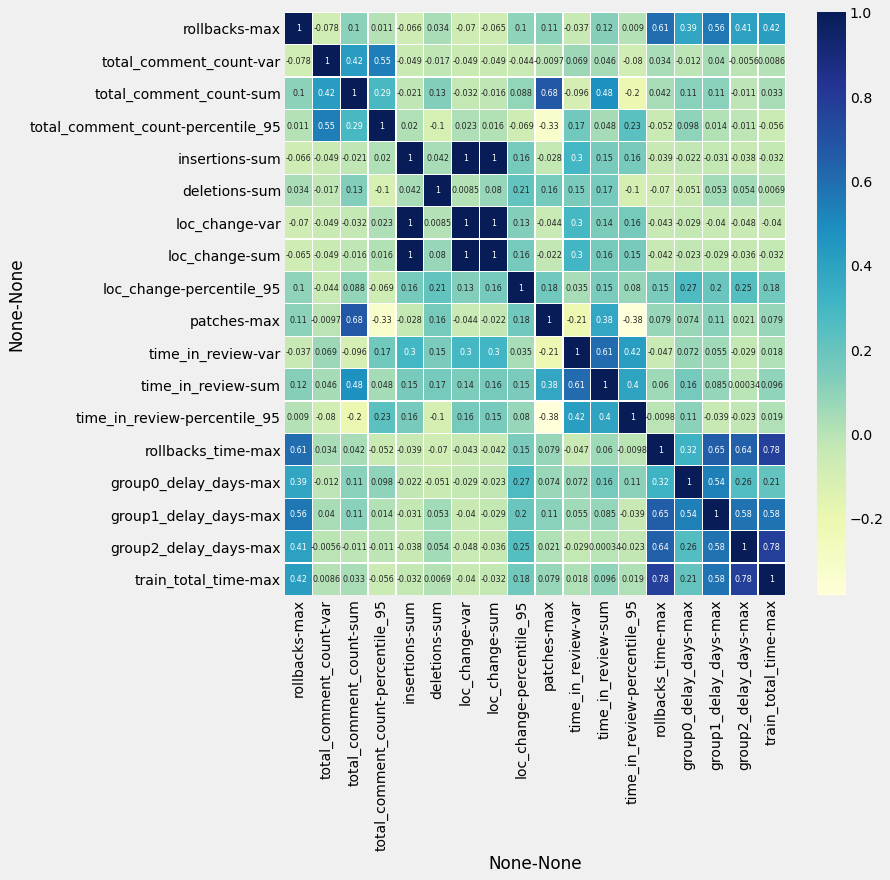

In [8]:
fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
sns.heatmap(agg_df.corr(), annot=True, cmap="YlGnBu", linewidths=0.3, annot_kws={"size": 8}, ax=ax)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()